# Лабораторная работа №6 “Кластеризация”

### *Набор данных **ex6data1.mat** представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит две переменные X<sub>1</sub> и X<sub>2</sub> - координаты точек, которые необходимо кластеризовать.*
### *Набор данных **bird_small.mat** представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит массив размером (16384, 3) - изображение 128x128 в формате RGB.*

## **Задание**

### 1. Загрузите данные **ex6data1.mat** из файла.

In [4]:
import heapq

import numpy as np

import matplotlib.pyplot as plt

from scipy import io
from scipy.spatial import distance_matrix

import cv2

from tqdm import tqdm_notebook

%matplotlib inline

In [6]:
ex6data1 = io.loadmat('Data/Lab 6/ex6data1.mat')
X = ex6data1['X']

### 2. Реализуйте функцию случайной инициализации K центров кластеров.

In [11]:
def random_centers(X, k):
    X_uniq = np.unique(X, axis=0)
    rand_idx = np.random.permutation(len(X_uniq))
    return X_uniq[rand_idx[:k]]

### 3. Реализуйте функцию определения принадлежности к кластерам.

In [12]:
def l2_dist(x, y, axis=1):
    return np.sum((x - y) ** 2, axis=axis) ** 0.5 

def assign_centers(X, centers):
    centr_dist = np.array([l2_dist(X, c) for c in centers])
    return np.argmin(centr_dist, axis=0)

### 4. Реализуйте функцию пересчета центров кластеров.

In [13]:
def update_centers(X, labels):
    k = labels.max() + 1
    return np.array([np.mean(X[labels == i], axis=0) for i in range(k)])

### 5. Реализуйте алгоритм K-средних.

In [14]:
def normalize(X):
    mean, std = X.mean(), X.std()
    return (X - mean) / std, mean, std

def kmeans(X, k, max_iters=1000):
    history = []
    centers = None
    X_norm, X_mean, X_std = normalize(X)
    
    for i in range(max_iters):
        centers = update_centers(X_norm, labels) if i else random_centers(X_norm, k)
        labels = assign_centers(X_norm, centers)

        if history and np.all(history[-1][1] == labels):
            break
        
        orig_centres = centers * X_std + X_mean
        history.append((orig_centres, labels))
        
    return history

In [16]:
history = kmeans(X, k=3)

### 6. Постройте график, на котором данные разделены на K=3 кластеров (при помощи различных маркеров или цветов), а также траекторию движения центров кластеров в процессе работы алгоритма.

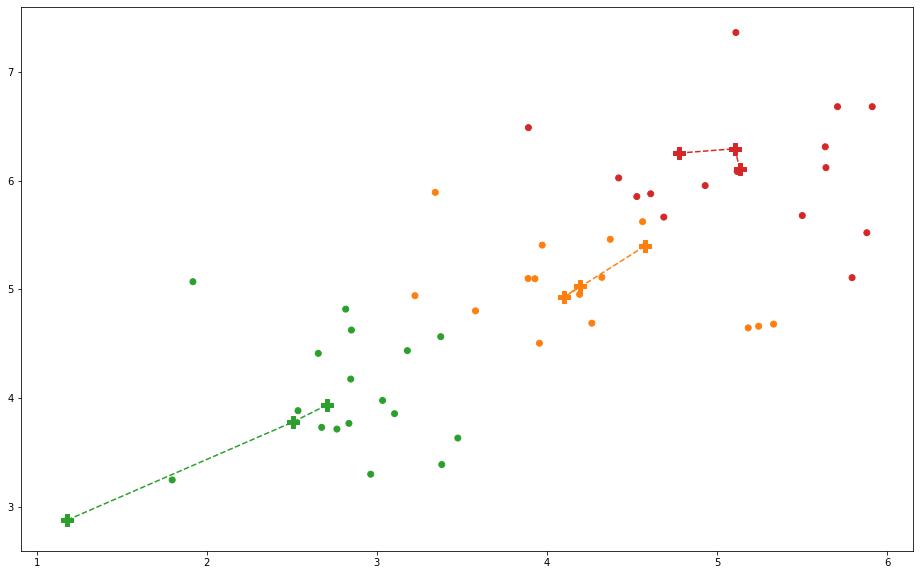

In [27]:
plt.figure(figsize=(16, 10))

colors = ['C1', 'C2', 'C3']
plt.scatter(X[:, 0], X[:, 1], c=[colors[x] for x in history[-1][1]], cmap='viridis')

for centers, labels in history:
    for center, color in zip(centers, colors):
        plt.scatter(center[0], center[1], c=color, marker='P', s=150)
        
for i in range(3):
    trajectory = np.array([centers[i] for centers, _ in history])
    plt.plot(trajectory[:, 0], trajectory[:, 1], c=colors[i], linestyle='--')

### 7. Загрузите данные **bird_small.mat**из файла.

In [29]:
bird_small = io.loadmat('Data/Lab 6/bird_small.mat')
A = bird_small['A']

### 8. С помощью алгоритма K-средних используйте 16 цветов для кодирования пикселей.

In [30]:
def cluster_image_kmeans(img, k=16):
    history = kmeans(img.reshape(-1, 3), k)
    centers, labels = history[-1]
    reduced_colors = np.uint8(centers)
    reduced_img = np.reshape([reduced_colors[x] for x in labels], img.shape)
    
    return reduced_img

bird_kmeans = cluster_image_kmeans(A)

### 9. Насколько уменьшился размер изображения? Как это сказалось на качестве?

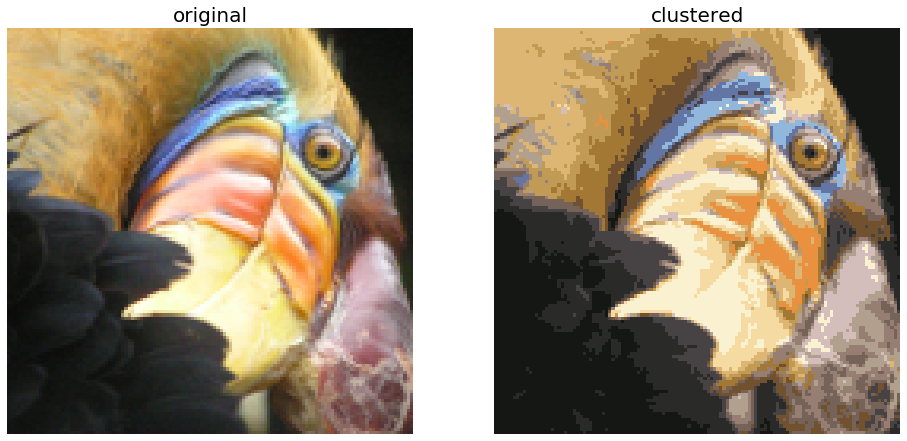

In [47]:
fig, ax = plt.subplots(1,2, figsize=(16, 16))
ax[0].imshow(A)
ax[0].axis('off')
ax[0].set_title('original', size=20)

ax[1].imshow(bird_kmeans)
ax[1].axis('off')
ax[1].set_title('clustered', size=20)

plt.show()

In [41]:
cv2.imwrite('Data/Lab 6/bird.png', cv2.cvtColor(A, cv2.COLOR_RGB2BGR))
cv2.imwrite('Data/Lab 6/bird_kmeans.png', cv2.cvtColor(bird_kmeans, cv2.COLOR_RGB2BGR))

!ls Data/Lab\ 6/*bird*.png -sh

16K 'Data/Lab 6/bird_kmeans.png'  36K 'Data/Lab 6/bird.png'


Размер изображения уменьшился более чем в два раза, при этом качество стало чуть хуже (видны пиксели, не такой плавный переход).

### 10. Реализуйте алгоритм K-средних на другом изображении.

In [51]:
car = cv2.imread('car_100.png')
car = cv2.cvtColor(car, cv2.COLOR_BGR2RGB)

In [52]:
car_kmeans = cluster_image_kmeans(car)

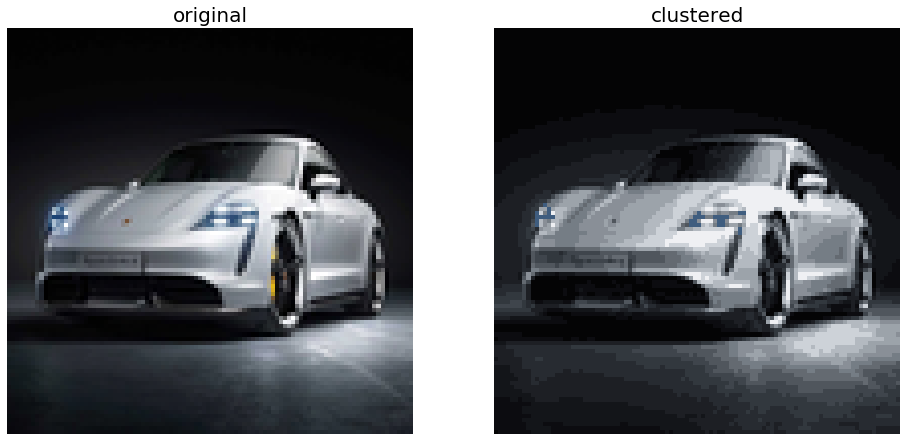

In [53]:
fig, ax = plt.subplots(1,2, figsize=(16, 16))
ax[0].imshow(car)
ax[0].axis('off')
ax[0].set_title('original', size=20)

ax[1].imshow(car_kmeans)
ax[1].axis('off')
ax[1].set_title('clustered', size=20)

plt.show()

### 11. Реализуйте алгоритм иерархической кластеризации на том же изображении. Сравните полученные результаты.

In [69]:
def calc_initial_dist(X):
    dist = distance_matrix(X, X)
    idx = np.arange(len(X))
    dist[idx, idx] = 10 ** 3
    
    return dist


def update_dist(u, v, clusters, dist, heap):        
    for s in clusters.keys():
        if s == u:
            continue

        d_su = (dist[u, s] + dist[v, s] + abs(dist[u, s] - dist[v, s])) / 2
        dist[s, u] = dist[u, s] = d_su
        heapq.heappush(heap, (d_su, u, s))
    
    dist[v, :] = dist[:, v] = 10 ** 3


def build_heap(dist, clusters):
    clist = list(clusters.keys())
    n = len(clist)
    heap = [(dist[clist[i], clist[j]], clist[i], clist[j]) 
            for i in range(n) for j in range(i + 1)]
    heapq.heapify(heap)
    
    return heap
    
    
def find_closest_clusters(heap, clusters):
    while True:
        d, u, v = heapq.heappop(heap)
        if u in clusters and v in clusters:
            return (u, v)


def hierarchical_clustering(X, k):
    # Distance matrix
    dist = calc_initial_dist(X)
    n = len(X)
    # Set of current clusters
    clusters = {i: [i] for i in range(n)}
    heap = build_heap(dist, clusters)
    
    for i in tqdm_notebook(range(n - k)):
        u, v = find_closest_clusters(heap, clusters)
        # Merge v in to u and delete u
        clusters[u].extend(clusters[v])
        del clusters[v]
        # Update distances
        update_dist(u, v, clusters, dist, heap)
        # Rebuild heap as it accumulates too much old distances
        if i > 0 and i % int(0.7 * n) == 0:
            heap = build_heap(dist, clusters)
    
    labels = {x:i for i, c in enumerate(clusters.values()) for x in c}
    labels = np.array([x[1] for x in sorted(labels.items())])
    
    return labels

In [70]:
def cluster_image_hierarchical(img, k):
    X = img.reshape(-1, 3)
    # We will cluster only unique colors to speed up clustering
    X_uniq = np.unique(X, axis=0)
    X_uniq_norm, _, _ = normalize(X_uniq)
    
    labels_uniq = hierarchical_clustering(X_uniq_norm, k=16)
    
    label_mapping = {tuple(x): l for x, l in zip(X_uniq, labels_uniq)}
    labels = np.array([label_mapping[tuple(x)] for x in X])
    reduced_colors = np.array([np.mean(X[labels == i], axis=0).astype(np.uint8) for i in range(k)])
    reduced_img = np.reshape([reduced_colors[x] for x in labels], img.shape)
    
    return reduced_img

In [71]:
car_hierarchical = cluster_image_hierarchical(car, k=16)

/home/z_ermak/miniconda3/envs/bsuir_labs/lib/python3.7/site-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


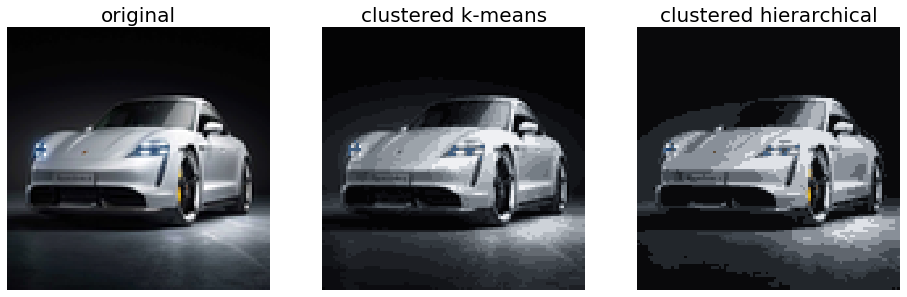

In [65]:
fig, ax = plt.subplots(1,3, figsize=(16, 16))
ax[0].imshow(car)
ax[0].axis('off')
ax[0].set_title('original', size=20)

ax[1].imshow(car_kmeans)
ax[1].axis('off')
ax[1].set_title('clustered k-means', size=20)

ax[2].imshow(car_hierarchical)
ax[2].axis('off')
ax[2].set_title('clustered hierarchical', size=20)

plt.show()

Мы видим, что кластеризация работает в обоих случаях, но с применением k-means картинка получилась более понятной, чем при иерархической классификации. Также стоит отметить, что иерархическая кластеризация работает значительно дольше.